In [1]:
# !unzip dataset.zip -d selfie

In [2]:
from torch import nn
import torch
import numpy as np
from loguru import logger
from contextlib import contextmanager
import sys
from torchmetrics import JaccardIndex
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from torchvision.transforms import functional
from torch.utils.data import Dataset
from torchvision import io
from torchvision.transforms import Resize
import os

DATASET_PATH = "../data/selfie/dataset"

torch.manual_seed(42)
np.random.seed(42)

# UNET

In [3]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True))

    def forward(self, x):
        return self.seq_block(x)

class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections

In [4]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x

In [5]:
class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down), # downscaled (so increase n maps 2x n_down times)
                               first_out_channels * (2 ** (n_down - 1)), # we have 2x channels here, because need to concat
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

# Utils

## Logging

In [6]:
@contextmanager
def loglevel(level):
    logger.remove()
    logger.add(sys.stdout, level=level)
    try:
        yield
    finally:
        logger.remove()
        logger.add(sys.stdout, level="DEBUG")

## Training utils

In [7]:
def train_epoch(
    model: nn.Module,
    data_loader,
    optimizer=None,
    criterion_fn=None,
    metric_fn=None,
    grad=True,
    mode='train'
):
    if mode == 'train':
        model.train()
    elif mode == 'eval':
        model.eval() # model.train(mode=False)
    else:
        raise ValueError(f"Incorrect value for argument `mode`: {mode}")

    loss_total = 0
    metric_total = 0

    for data in data_loader:
        image = data["image"].cuda()
        mask = data["mask"].cuda()

        output = model(image)

        if criterion_fn:
            loss = criterion_fn(output, mask)

        if metric_fn:
            metric_total += metric_fn(output.cpu(), mask.cpu() > metric_fn.threshold).item()

        if grad:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if criterion_fn:
            loss_total += loss.item()


    data_size = len(data_loader)
    loss_ret, metric_ret = None, None
    if criterion_fn:
        loss_ret = loss_total / data_size
    if metric_fn:
        metric_ret = metric_total / data_size
    return loss_ret, metric_ret


In [8]:
def train(
    model: nn.Module,
    optimizer,
    train_loader,
    test_loader,
    num_epochs,
    save_dir
):
    os.makedirs(save_dir, exist_ok=True)
    criterion = nn.BCEWithLogitsLoss()
    metric = JaccardIndex(task="binary")
    optimizer = optimizer(model.parameters())

    train_losses, train_metrics = [], []
    test_losses, test_metrics = [], []

    logger.info(
        f"Starting training model {model.__class__.__name__} with optimizer {optimizer.__class__.__name__}"
    )
    for epoch in range(num_epochs):
        train_loss, train_metric = train_epoch(
            model=model,
            data_loader=train_loader,
            optimizer=optimizer,
            criterion_fn=criterion,
            metric_fn=metric,
            mode="train",
        )

        train_losses.append(train_loss)
        train_metrics.append(train_metric)

        with torch.no_grad():
            test_loss, test_metric = train_epoch(
                model=model,
                data_loader=test_loader,
                criterion_fn=criterion,
                metric_fn=metric,
                grad=False,
                mode="eval",
            )

        test_losses.append(test_loss)
        test_metrics.append(test_metric)

        logger.info(
            f"epoch {epoch} finished with results: train loss -- {train_loss}, train metric -- {train_metric}, test loss -- {test_loss}, test metric -- {test_metric}"
        )

        torch.save(model.state_dict(), os.path.join(save_dir, f"epoch_{epoch}.pkl"))

    return {
        "optimizer": optimizer.__class__.__name__,
        "train_losses": train_losses,
        "train_metrics": train_metrics,
        "test_losses": test_losses,
        "test_metrics": test_metrics,
    }

In [9]:
def run_train(model, optimizer, num_epochs, train_loader, test_loader, save_dir):
    logger.debug(type(model))

    return train(model, optimizer, train_loader, test_loader, num_epochs, save_dir)

## Data manipulation and visualization

In [10]:
def beautify_results(results):
    results['epoch'] = list(range(len(results['train_losses'])))

    return pd.json_normalize(results).explode(column=['train_losses', 'train_metrics', 'test_losses', 'test_metrics', 'epoch'])

In [11]:
def plot_train_val(df, value_vars, title):
    g = sns.lineplot(data=df.melt(id_vars=['epoch'], value_vars=value_vars), x='epoch', y='value', hue='variable');
    g.set_title(title)
    # g.set_title(f"{plot_df['optimizer'].iloc[0]}, {{ lr = {plot_df['params.lr'].iloc[0]}, weight_decay = {plot_df['params.weight_decay'].iloc[0]} }}")

In [12]:
def plot_images(image_list):
    _, axes = plt.subplots(ncols=len(image_list))
    for i, image in enumerate(image_list):
        axes[i].imshow(functional.to_pil_image(image))
        axes[i].axis("off")
    plt.show()

In [13]:
def get_botN(model, n, metric_fn, dataset):
    results = []
    with torch.no_grad():
        for i, data in enumerate(dataset):
            image, mask = data['image'].cuda(), data['mask']
            pred = model(image.unsqueeze(0))[0].cpu()
            results.append((i, metric_fn(pred, mask > metric_fn.threshold).item()))
    results.sort(key=lambda x: x[1])
    return [i for i, _ in results[:n]]

def plot_botN(model, n, metric_fn, dataset):
    for i in get_botN(model, n, metric_fn, dataset):
        data = dataset[i]
        image, mask = data['image'].cuda(), data['mask']
        pred = model(image.unsqueeze(0))[0].cpu()
        plot_images([image, nn.functional.sigmoid(pred), mask])


# Train/test split

In [14]:
IMAGE_SIZE = (256, 256)

class SelfieDataset(Dataset):
    def __init__(self, images, masks, transform_fn):
        self.__images = images
        self.__masks = masks
        self.__transform_fn = transform_fn

    def set_transform_fn(self, transform_fn):
        self.__transform_fn = transform_fn


    def __len__(self):
        return len(self.__images)

    def __getitem__(self, index):
        return {
            "image": self.__transform_fn(io.read_image(self.__images[index]) / 255),
            "mask": self.__transform_fn(io.read_image(self.__masks[index]) / 255)
        }

In [15]:
def train_test_split(dataset, train_ratio):
    np.random.shuffle(dataset)
    images, masks = zip(*dataset)
    threshold = int(np.floor(len(images) * train_ratio))

    logger.debug(threshold)
    return SelfieDataset(images[:threshold], masks[:threshold], Resize(IMAGE_SIZE)), SelfieDataset(images[threshold:], masks[threshold:], Resize(IMAGE_SIZE))


In [16]:

images_path = os.path.join(DATASET_PATH, "images")
masks_path = os.path.join(DATASET_PATH, "masks")

dataset = [
    (
        os.path.join(images_path, filename),
        os.path.join(masks_path, f'{os.path.splitext(filename)[0]}.png')
    ) for filename in os.listdir(images_path)
]


In [17]:
with loglevel("DEBUG"):
    train_dataset, test_dataset = train_test_split(dataset, 0.8)

2024-06-28 17:54:39.496 | DEBUG    | __main__:train_test_split:6 - 1600


# Переобучение

In [36]:
from torch.utils.data import DataLoader, Subset
with loglevel("INFO"):
    BATCH_SIZE = 4
    train_loader = DataLoader(Subset(train_dataset, range(BATCH_SIZE)), batch_size=BATCH_SIZE)
    test_loader = DataLoader(Subset(test_dataset, range(BATCH_SIZE)), batch_size=BATCH_SIZE)
    model = UNET(3, 16, 1).cuda()
    results = run_train(
        model=model,
        optimizer=torch.optim.Adam,
        num_epochs=100,
        train_loader=train_loader,
        test_loader=test_loader,
        save_dir="overfitting"
    )

2024-06-28 12:49:55.850 | INFO     | __main__:train:17 - Starting training model UNET with optimizer Adam
2024-06-28 12:49:56.465 | INFO     | __main__:train:46 - epoch 0 finished with results: train loss -- 0.695201575756073, train metric -- 0.24341946840286255, test loss -- 0.693343997001648, test metric -- 0.0
2024-06-28 12:49:56.702 | INFO     | __main__:train:46 - epoch 1 finished with results: train loss -- 0.6339142918586731, train metric -- 0.48410922288894653, test loss -- 0.6933213472366333, test metric -- 0.0
2024-06-28 12:49:56.940 | INFO     | __main__:train:46 - epoch 2 finished with results: train loss -- 0.5939740538597107, train metric -- 0.6461789011955261, test loss -- 0.6933204531669617, test metric -- 0.0
2024-06-28 12:49:57.179 | INFO     | __main__:train:46 - epoch 3 finished with results: train loss -- 0.5632961988449097, train metric -- 0.7000973224639893, test loss -- 0.6932065486907959, test metric -- 0.0
2024-06-28 12:49:57.424 | INFO     | __main__:train:46

In [37]:
df = beautify_results(results)

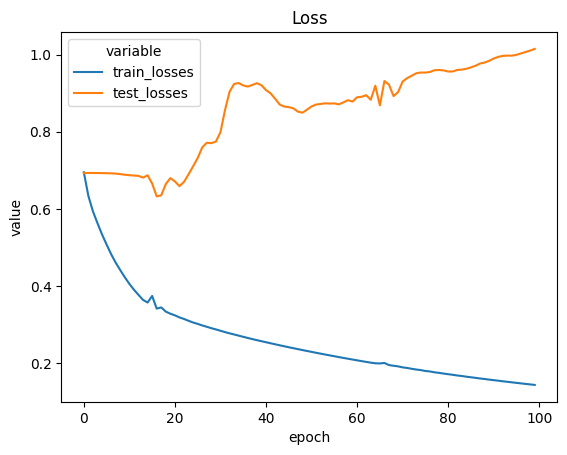

In [38]:
plot_train_val(df, ['train_losses', 'test_losses'], "Loss")

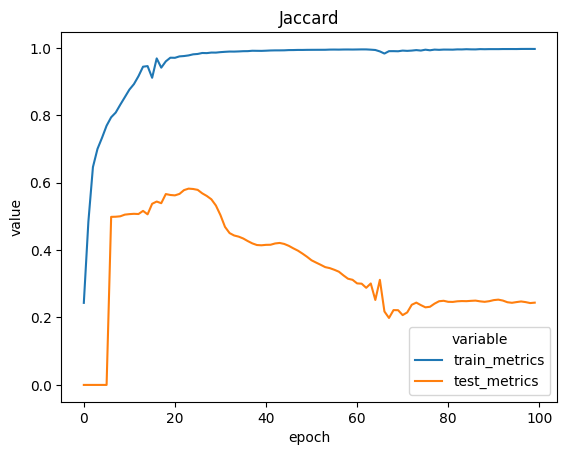

In [39]:
plot_train_val(df, ['train_metrics', 'test_metrics'], "Jaccard")

# Обучение

In [40]:
with loglevel("INFO"):
    BATCH_SIZE = 20
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    model = UNET(3, 16, 1).cuda()
    results = run_train(
        model=model,
        optimizer=torch.optim.Adam,
        num_epochs=30,
        train_loader=train_loader,
        test_loader=test_loader,
        save_dir="train"
    )

2024-06-28 12:51:21.369 | INFO     | __main__:train:17 - Starting training model UNET with optimizer Adam
2024-06-28 12:52:09.642 | INFO     | __main__:train:46 - epoch 0 finished with results: train loss -- 0.4146411407738924, train metric -- 0.7363379519432783, test loss -- 0.2709302805364132, test metric -- 0.8353106826543808
2024-06-28 12:52:56.197 | INFO     | __main__:train:46 - epoch 1 finished with results: train loss -- 0.2343739528208971, train metric -- 0.8580092467367649, test loss -- 0.19252802580595016, test metric -- 0.8694097191095352
2024-06-28 12:53:41.241 | INFO     | __main__:train:46 - epoch 2 finished with results: train loss -- 0.16571287177503108, train metric -- 0.8946951754391194, test loss -- 0.16424351297318934, test metric -- 0.88491151034832
2024-06-28 12:54:25.950 | INFO     | __main__:train:46 - epoch 3 finished with results: train loss -- 0.12777502797544002, train metric -- 0.9172200068831444, test loss -- 0.13136023953557013, test metric -- 0.91234654

In [41]:
df = beautify_results(results)

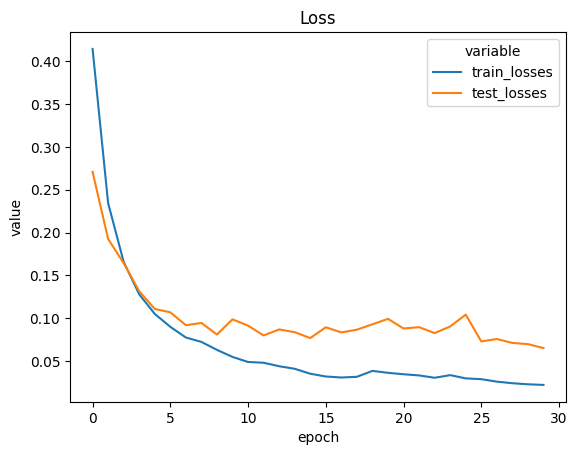

In [42]:
plot_train_val(df, value_vars=['train_losses', 'test_losses'], title="Loss")

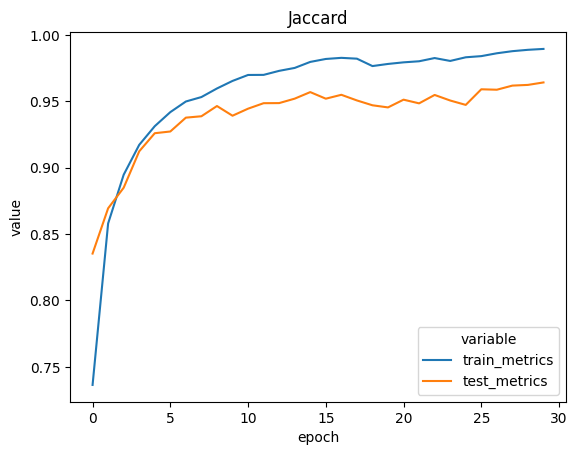

In [43]:
plot_train_val(df, value_vars=['train_metrics', 'test_metrics'], title="Jaccard")

In [46]:
df[df['test_losses'] == df['test_losses'].min()]

,optimizer,train_losses,train_metrics,test_losses,test_metrics,epoch
0,Adam,0.021885,0.989502,0.064944,0.964252,29


In [47]:
model = UNET(3, 16, 1).cuda()
model.load_state_dict(torch.load(os.path.join("train", "epoch_29.pkl")))
model.eval()

UNET(
  (encoder): Encoder(
    (enc_layers): ModuleList(
      (0): CNNBlocks(
        (layers): ModuleList(
          (0): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (1): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): CNNBlocks(
        (layers): ModuleList(
          (0): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(16,

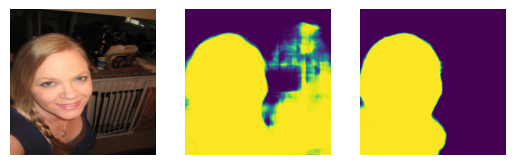

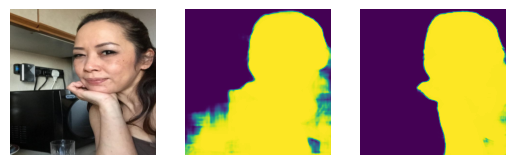

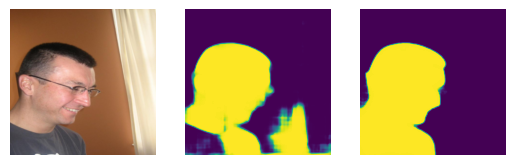

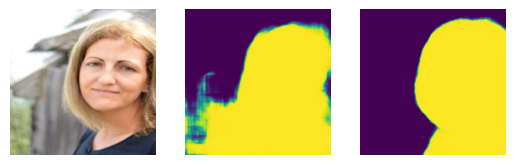

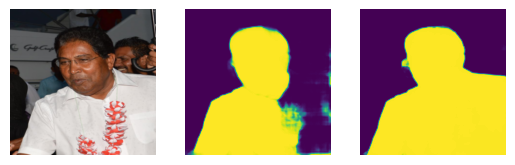

In [50]:
plot_botN(model, 5, JaccardIndex(task="binary"), test_dataset)

# Улучшение без изменения архитектуры

## Аугментации

In [18]:
import copy
from torchvision import transforms
augmentation_fn = transforms.Compose(
    [
        Resize(IMAGE_SIZE),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.RandomHorizontalFlip(p=0.5)
    ]
)

train_augmented = copy.copy(train_dataset)
train_augmented.set_transform_fn(augmentation_fn)

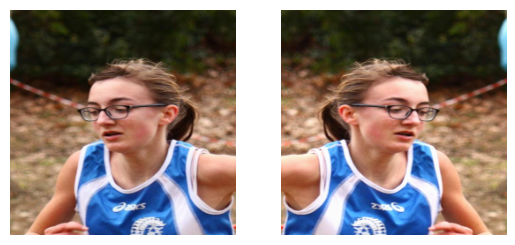

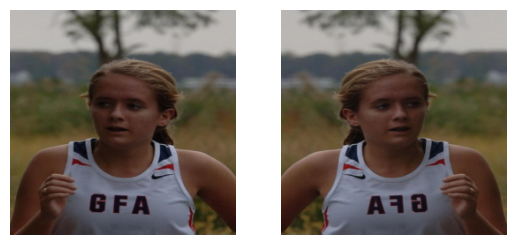

In [19]:
plot_images([train_dataset[0]['image'], train_augmented[0]['image']])
plot_images([train_dataset[1]['image'], train_augmented[1]['image']])

In [55]:
with loglevel("INFO"):
    BATCH_SIZE = 10
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    train_dataset_extended = torch.utils.data.ConcatDataset([train_dataset, train_augmented])
    train_loader_extended = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    model = UNET(3, 16, 1).cuda()
    results = run_train(
        model=model,
        optimizer=torch.optim.Adam,
        num_epochs=30,
        train_loader=train_loader,
        test_loader=test_loader,
        save_dir="augmentations"
    )

2024-06-28 13:27:52.437 | INFO     | __main__:train:17 - Starting training model UNET with optimizer Adam
2024-06-28 13:28:36.526 | INFO     | __main__:train:46 - epoch 0 finished with results: train loss -- 0.3863392392173409, train metric -- 0.7554791830480099, test loss -- 0.2563686527311802, test metric -- 0.847936874628067
2024-06-28 13:29:21.895 | INFO     | __main__:train:46 - epoch 1 finished with results: train loss -- 0.21627231482416392, train metric -- 0.8656001470983028, test loss -- 0.18073657751083375, test metric -- 0.8827116385102272
2024-06-28 13:30:05.818 | INFO     | __main__:train:46 - epoch 2 finished with results: train loss -- 0.15820738738402723, train metric -- 0.8977036751806736, test loss -- 0.14696722384542227, test metric -- 0.9017185270786285
2024-06-28 13:30:50.683 | INFO     | __main__:train:46 - epoch 3 finished with results: train loss -- 0.12504224432632327, train metric -- 0.9180959716439248, test loss -- 0.13091525360941886, test metric -- 0.912226

In [21]:
df = pd.read_csv("augmented_results/augmentations/results.csv")

/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will n

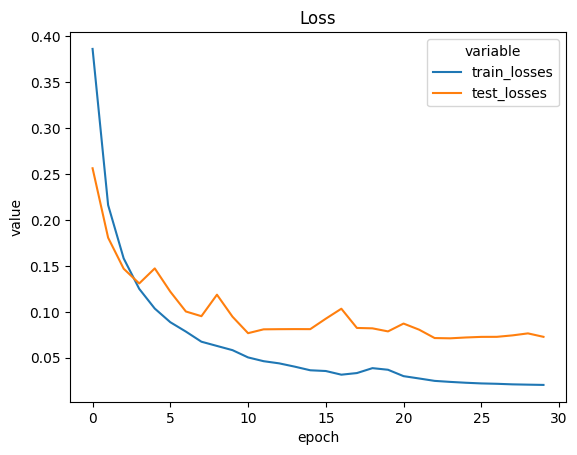

In [22]:
plot_train_val(df, ['train_losses', 'test_losses'], 'Loss')

/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will n

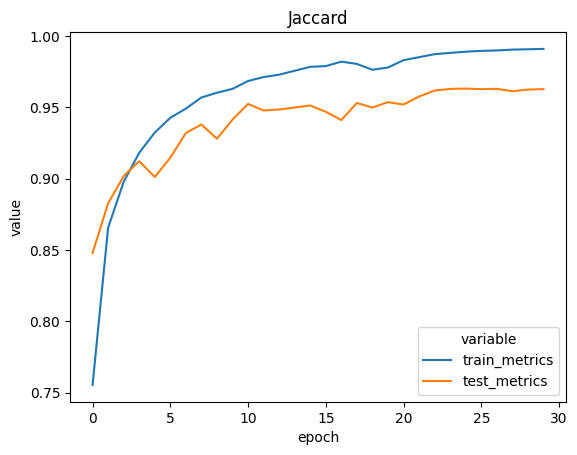

In [23]:
plot_train_val(df, ['train_metrics', 'test_metrics'], 'Jaccard')

In [24]:
df[df['test_losses'] == df['test_losses'].min()]

,Unnamed: 0,optimizer,train_losses,train_metrics,test_losses,test_metrics,epoch
23,0,Adam,0.023701,0.988057,0.071158,0.962805,23


In [ ]:
model = UNET(3, 16, 1).cuda()
model.load_state_dict(torch.load("augmentations/epoch_23.pkl"))
model.eval()

UNET(
  (encoder): Encoder(
    (enc_layers): ModuleList(
      (0): CNNBlocks(
        (layers): ModuleList(
          (0): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (1): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): CNNBlocks(
        (layers): ModuleList(
          (0): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(16,

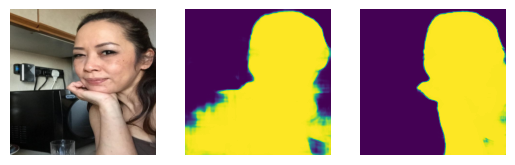

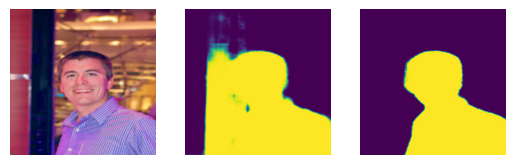

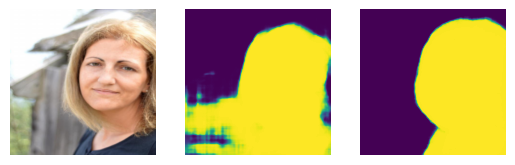

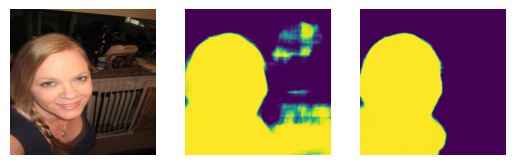

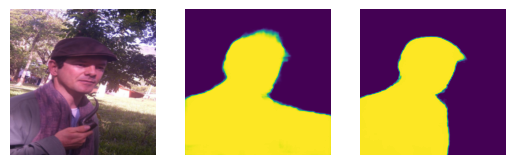

In [ ]:
plot_botN(model, 5, JaccardIndex(task="binary"), test_dataset)

## Гиперпараметры

In [62]:
def tune_neurons(
    possible_num_neurons,
    train_loader,
    test_loader,
    save_dir
):
    for neurons in possible_num_neurons:
        model = UNET(3, neurons, 1).cuda()
        os.makedirs(os.path.join(save_dir, f"neurons_{neurons}"), exist_ok=True)
        results = run_train(
            model=model,
            optimizer=torch.optim.Adam,
            num_epochs=10,
            train_loader=train_loader,
            test_loader=test_loader,
            save_dir=os.path.join(save_dir, f"neurons_{neurons}")
        )
        df = beautify_results(results)
        df.to_csv(os.path.join(save_dir, f"neurons_{neurons}", "results.csv"))


In [63]:
with loglevel("INFO"):
    BATCH_SIZE = 10
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    tune_neurons(
        [12, 24],
        train_loader,
        test_loader,
        "hyperparams"
    )

2024-06-28 13:52:41.083 | INFO     | __main__:train:17 - Starting training model UNET with optimizer Adam
2024-06-28 13:53:24.910 | INFO     | __main__:train:46 - epoch 0 finished with results: train loss -- 0.3717763415537775, train metric -- 0.7620771799236536, test loss -- 0.257027492672205, test metric -- 0.8245198786258697
2024-06-28 13:54:08.169 | INFO     | __main__:train:46 - epoch 1 finished with results: train loss -- 0.20276610190048813, train metric -- 0.8695949729532003, test loss -- 0.1628956191241741, test metric -- 0.8852302327752113
2024-06-28 13:54:49.930 | INFO     | __main__:train:46 - epoch 2 finished with results: train loss -- 0.14481967804022133, train metric -- 0.9043282456696033, test loss -- 0.12997650001198052, test metric -- 0.909926125407219
2024-06-28 13:55:32.022 | INFO     | __main__:train:46 - epoch 3 finished with results: train loss -- 0.11444516037590802, train metric -- 0.923454313352704, test loss -- 0.1338712278753519, test metric -- 0.9036192178

In [40]:
df_12 = pd.read_csv("hyperparams_results/hyperparams/neurons_12/results.csv")

/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will n

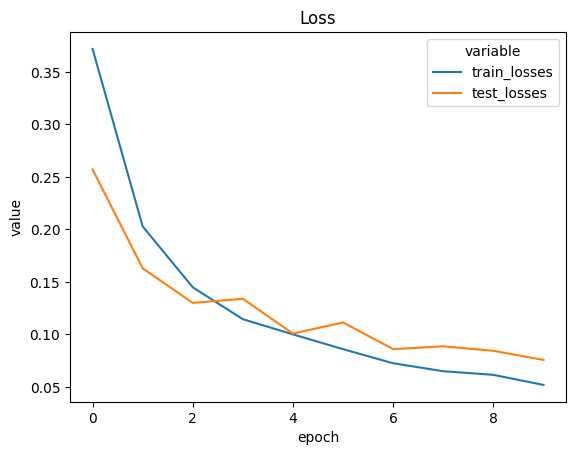

In [41]:
plot_train_val(df_12, ['train_losses', 'test_losses'], 'Loss')

/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will n

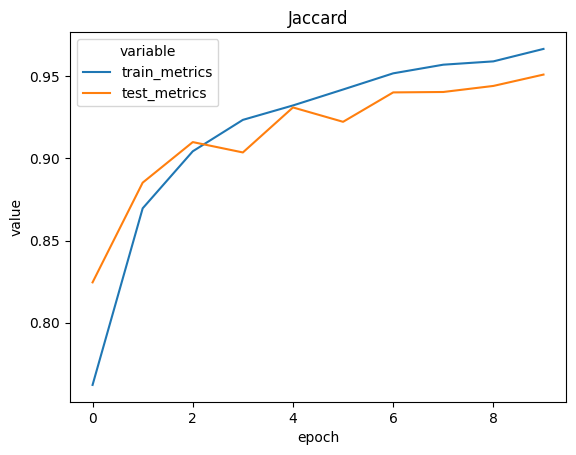

In [42]:
plot_train_val(df_12, ['train_metrics', 'test_metrics'], 'Jaccard')

In [43]:
df_12[df_12['test_losses'] == df_12['test_losses'].min()]

,Unnamed: 0,optimizer,train_losses,train_metrics,test_losses,test_metrics,epoch
9,0,Adam,0.051871,0.966651,0.075657,0.951027,9


In [ ]:
model = UNET(3, 12, 1).cuda()
model.load_state_dict(torch.load("hyperparams/neurons_12/epoch_9.pkl"))
model.eval()

UNET(
  (encoder): Encoder(
    (enc_layers): ModuleList(
      (0): CNNBlocks(
        (layers): ModuleList(
          (0): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (1): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): CNNBlocks(
        (layers): ModuleList(
          (0): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(12,

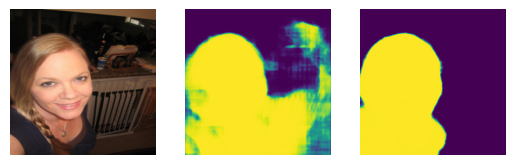

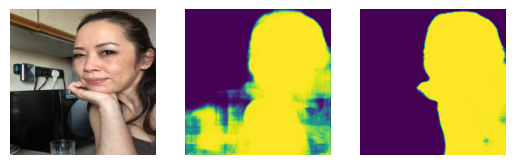

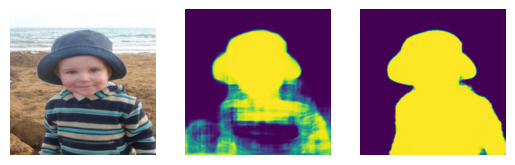

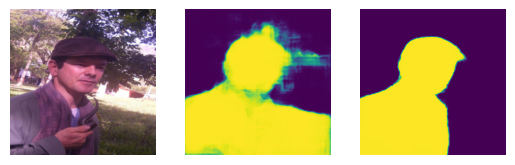

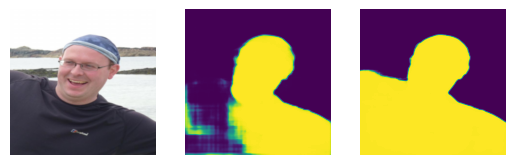

In [ ]:
plot_botN(model, 5, JaccardIndex(task="binary"), test_dataset)

In [44]:
df_24 = pd.read_csv("hyperparams_results/hyperparams/neurons_24/results.csv")

/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will n

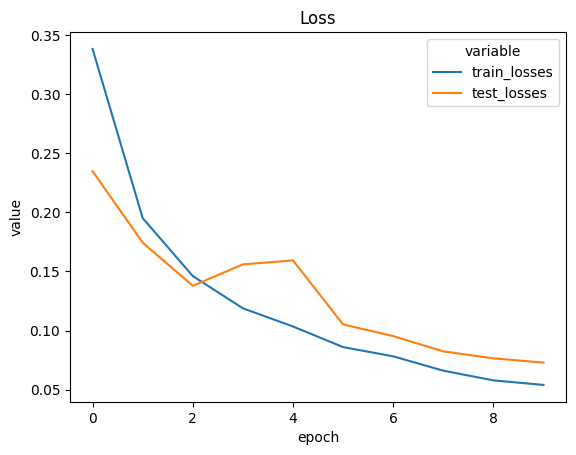

In [48]:
plot_train_val(df_24, ['train_losses', 'test_losses'], 'Loss')

/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/zenes/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will n

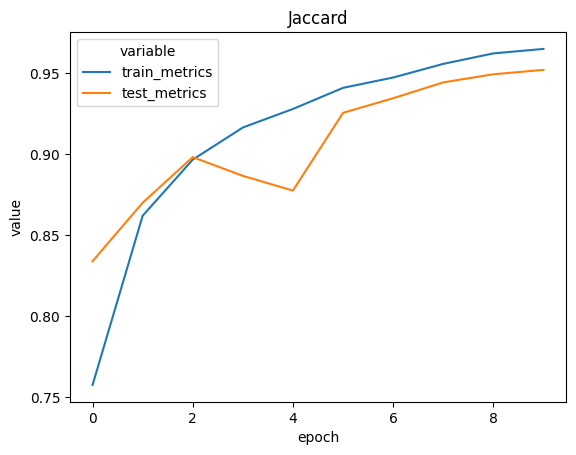

In [49]:
plot_train_val(df_24, ['train_metrics', 'test_metrics'], 'Jaccard')

In [45]:
df_24[df_24['test_losses'] == df_24['test_losses'].min()]

,Unnamed: 0,optimizer,train_losses,train_metrics,test_losses,test_metrics,epoch
9,0,Adam,0.054033,0.964774,0.072902,0.95182,9


In [ ]:
model = UNET(3, 24, 1).cuda()
model.load_state_dict(torch.load("hyperparams/neurons_24/epoch_9.pkl"))
model.eval()

UNET(
  (encoder): Encoder(
    (enc_layers): ModuleList(
      (0): CNNBlocks(
        (layers): ModuleList(
          (0): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (1): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): CNNBlocks(
        (layers): ModuleList(
          (0): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(24,

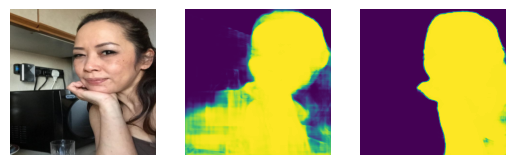

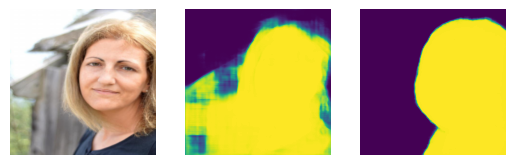

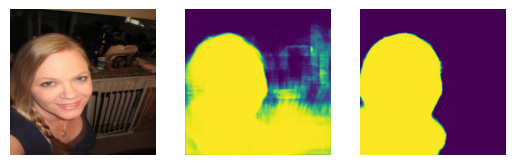

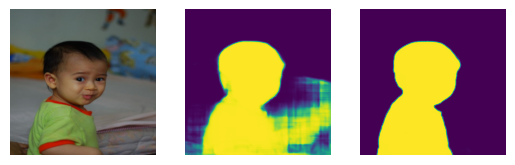

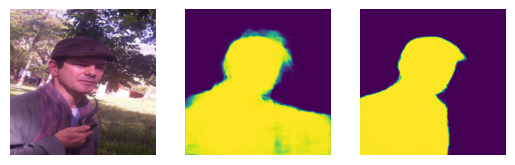

In [ ]:
plot_botN(model, 5, JaccardIndex(task="binary"), test_dataset)

## Test-time аугментации

In [ ]:
class Wrapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.__unet = UNET(3, 16, 1)

    def forward(self, x):
        x_flipped = functional.hflip(x)
        y = self.__unet(x)
        y_flipped = self.__unet(x_flipped)
        y_unflipped = functional.hflip(y_flipped)

        return torch.mean(
            torch.stack([y, y_unflipped]),
            dim=0
        )



In [ ]:
wrapped = Wrapper().cuda()
wrapped.unet.load_state_dict(torch.load(f"train/epoch_29.pkl"))

<All keys matched successfully>

In [ ]:
wrapped_loss, wrapped_jaccard = train_epoch(wrapped, test_loader, criterion_fn=nn.BCEWithLogitsLoss(), metric_fn=JaccardIndex(task="binary"), grad=False, mode="eval")
wrapped_loss, wrapped_jaccard

(0.055326348170638084, 0.9684634163975716)

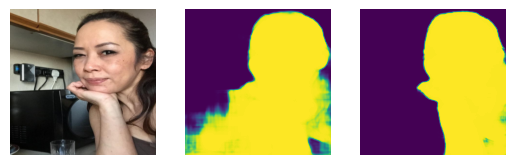

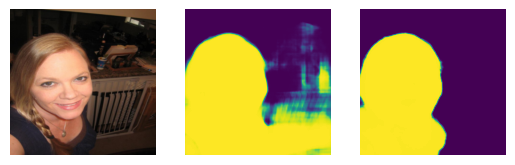

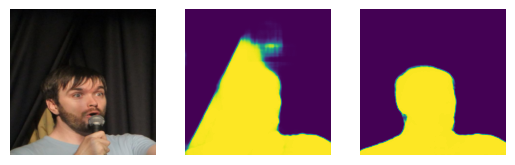

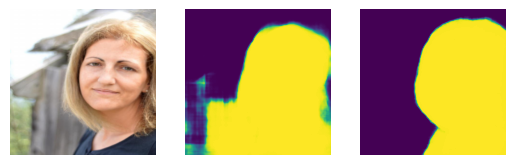

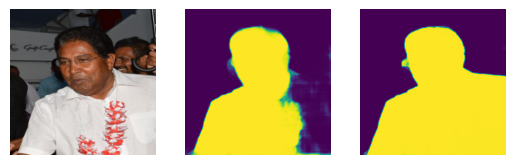

In [ ]:
plot_botN(wrapped, 5, JaccardIndex(task="binary"), test_dataset)

# Результаты

In [50]:
res = pd.read_csv("best_results.csv")
res

,type,loss,jaccard,epoch
0,base,0.064944,0.964252,29.0
1,augmentations,0.071158,0.962805,23.0
2,neurons_12,0.075657,0.951027,9.0
3,neurons_24,0.072902,0.951820,9.0
4,test_time,0.055326,0.968463,NaN
